In [1]:
from database_api import *
from Year import *
from Month import *
import matplotlib.pyplot as plt
import locale
locale.setlocale(locale.LC_ALL, '') 

'C/UTF-8/C/C/C/C'

In [2]:
def plot(years):
    fig = plt.figure(figsize=(16,9))
    for year in years:
        months = [Month(i,year.year_no) for i in range(1,13)]
        values = []
        try:
            for month in months:
                values.append(-round(month.tagStruct["Essen"]["Lebensmittel"],2))
        except AttributeError:
            print("Gotcha")
        plt.plot(values,label=year.year_no)
        plt.legend()
    plt.show()

In [3]:
computeBalances()
years = []
years.append(Year(2020))
years.append(Year(2021))
years.append(Year(2022))

In [4]:
months_years = []
for year in years:
    months = []
    for i in range(1,13):
        month = Month(i,year.year_no)
        if len(month.monthly_transacts) > 0:
            months.append(month)
    months_years.append(months)

In [44]:
for year in years:
    all_tags = {}
    biggest_tag = list(year.tagStruct.keys())[0]
    biggest_tag_value = list(list(year.tagStruct.values())[0].values())[0]
    for tag,subtags in year.tagStruct.items():
        for subtag, value in subtags.items():
            all_tags[(tag,subtag)] = value
    sorted_tags = {k: v for k, v in sorted(all_tags.items(), key=lambda item: item[1])}

In [57]:
def computePerMonthPerTagExpenses(months_years,tags):
    expense_dict = {}
    for tag in tags:
        if type(tag) is tuple:
            tag_label = tag[0]+" - "+tag[1]
        else:
            tag_label = tag
        expense_dict[tag_label] = {}   
        for months in months_years:
            year_no = months[0].year_no
            expense_dict[tag_label][year_no] = {}
            for month in months:
                    if type(tag) is tuple: 
                        if tag[0] in month.tagStruct.keys():
                            if tag[1] in month.tagStruct[tag[0]].keys():
                                expense_dict[tag_label][year_no][month.month_name] = -round(month.tagStruct[tag[0]][tag[1]],2)
                            else:
                                expense_dict[tag_label][year_no][month.month_name] = 0
                    else:
                        if tag in month.tagStruct.keys():
                            expense_dict[tag_label][year_no][month.month_name] = -round(sum([month.tagStruct[tag][sub_tag] for sub_tag in month.tagStruct[tag].keys()],2))                            
                        else:
                            expense_dict[tag_label][year_no][month.month_name] = 0
    return expense_dict

In [58]:
def computePerMonthExpenses(months_years,tags):
    expense_dict = {}
    for months in months_years:
            year_no = months[0].year_no
            expense_dict[year_no] = {}
            for month in months:
                expense_dict[year_no][month.month_name] = -month.total_spent
    return expense_dict

In [59]:
tags = [tag for tag in sorted_tags]
tags = tags[:5]
expense_dict = computePerMonthPerTagExpenses(months_years,tags)
all_tags_expense_dict = computePerMonthExpenses(months_years,tags)

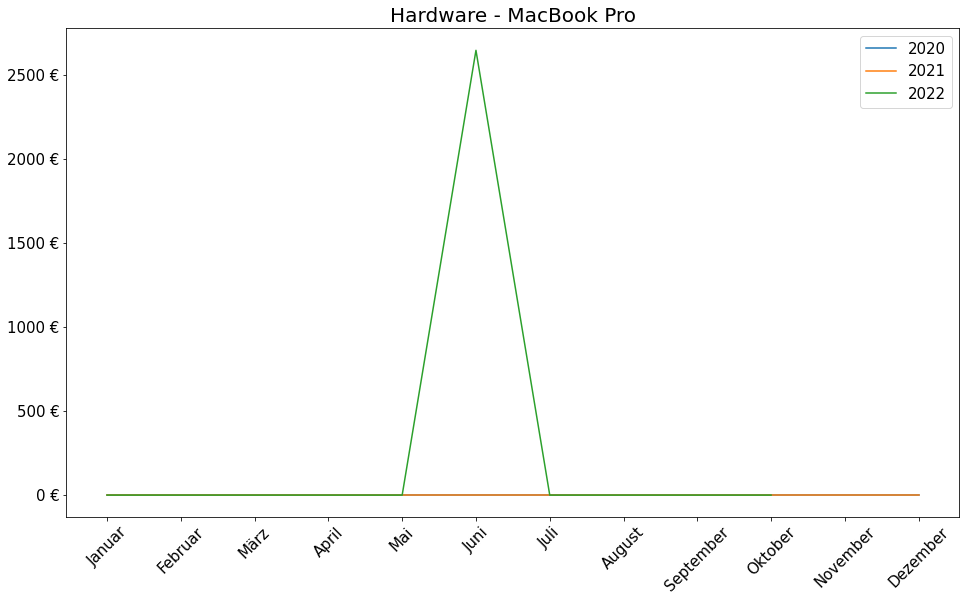

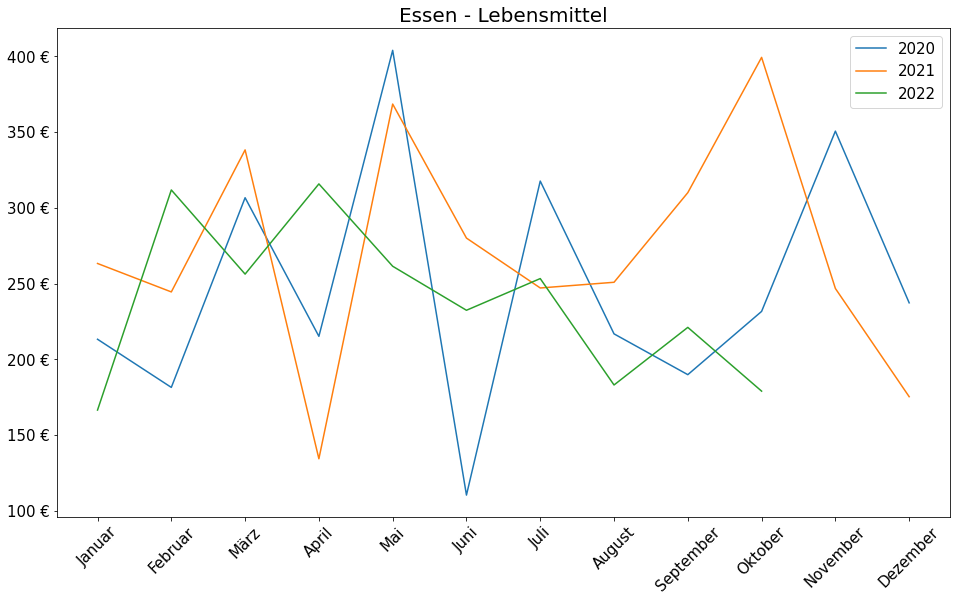

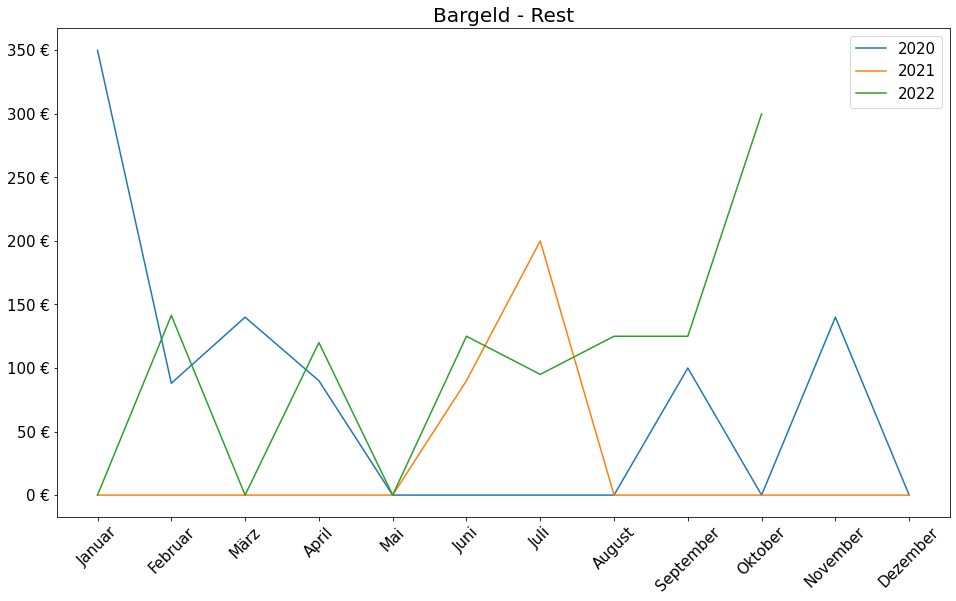

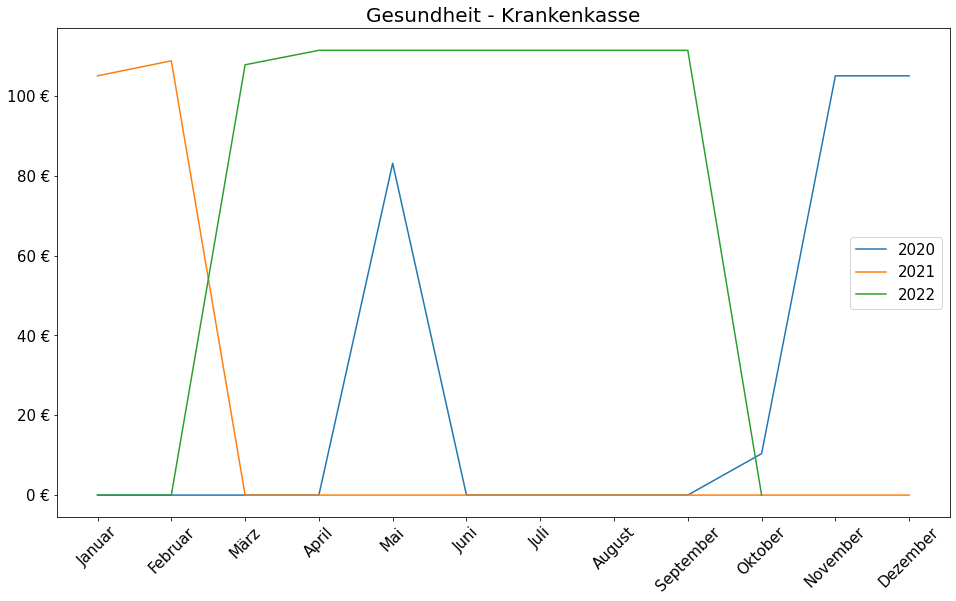

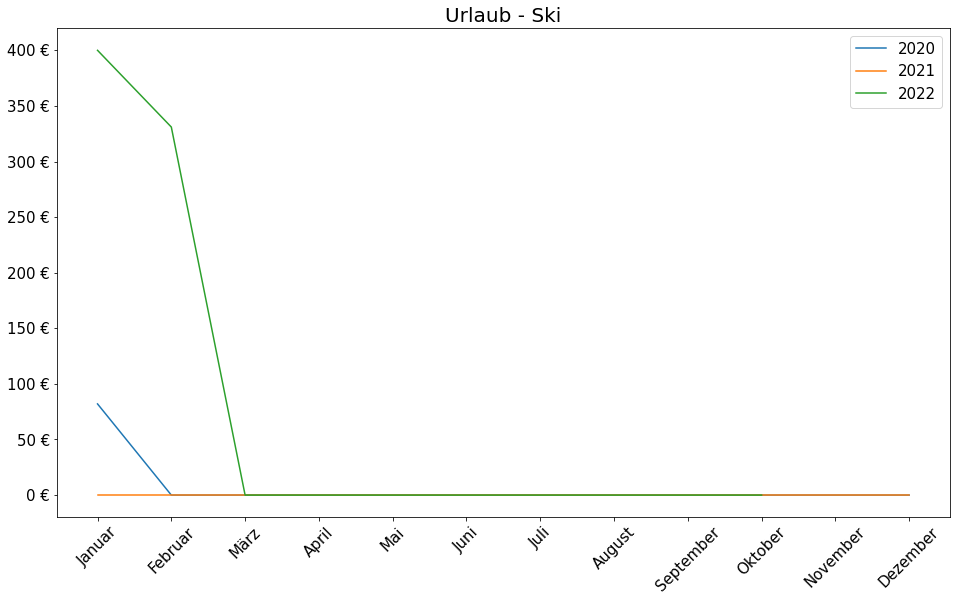

In [62]:
plotPerTagExpenses(expense_dict)

In [63]:
def plotPerTagExpenses(expense_dict):
    for tag,expenses in expense_dict.items():
        fig = plt.figure(figsize=(16,9))
        ax = plt.gca()
        ax.yaxis.set_major_formatter('{x:n} €')
        ax.set_title(tag, fontsize = 20)
        plt.xticks(rotation=45)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=12)
        for year,months in expenses.items():
            values = []
            labels = []
            for month,value in months.items():
                values.append(value)
                labels.append(month)
            plt.plot(labels, values, label = year)
            plt.legend(fontsize = 15)
    plt.show()
    
def plotAllTagsExpenses(expense_dict):
    fig = plt.figure(figsize=(16,9))
    ax = plt.gca()
    ax.yaxis.set_major_formatter('{x:n} €')
    ax.set_title("All", fontsize = 20)
    plt.xticks(rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    for year,months in expense_dict.items():
        values = []
        labels = []
        for month,value in months.items():
            values.append(value)
            labels.append(month)
        plt.plot(labels, values, label = year)
        plt.legend(fontsize = 15)
    plt.show()